### AWS ChatBot Using LangChain

In [107]:
from langchain_openai import ChatOpenAI
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.tools import WikipediaQueryRun, ArxivQueryRun
from langchain.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
import os

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pdfminer")


In [109]:
OPENAI_API_KEY = "YOUR_API"

In [111]:
# Provide your key directly
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)
embeddings = OpenAIEmbeddings()


In [113]:
pdf_path = r"C:\Users\PRATIK\Downloads\aws_certified_ai_practitioner__slides.pdf"  

loader = PyMuPDFLoader(pdf_path)
docs = loader.load()

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
chunks = splitter.split_documents(docs)

vectorstore = FAISS.from_documents(chunks, embedding=embeddings)
retriever = vectorstore.as_retriever()
rag_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)


In [61]:
wiki = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
arxiv = ArxivQueryRun(api_wrapper=ArxivAPIWrapper())


In [74]:
def route_query(user_query):
    """
    Classify user query to choose the correct reasoning path.
    """

    router_prompt = f"""
    You are a smart routing agent that decides which module should answer the user's question.

    --- CONTEXT ---
    The system has:
    1. A Local RAG (Retrieval-Augmented Generation) system built on AWS AI Practitioner course PDF.
    2. A Wikipedia tool for general knowledge.
    3. An Arxiv tool for research paper and academic queries.
    4. A language model (LLM) for general conversation or reasoning tasks.

    --- INSTRUCTIONS ---
    Carefully read the user query and decide which module is most suitable.
    Respond with only one of these exact words:
      • RAG     → when the query is directly related to AWS, cloud, AI services, ML terms from AWS syllabus, or the PDF content.
      • WIKI    → when the query is about general world knowledge, historical facts, company info, or non-AWS concepts.
      • ARXIV   → when the query is about scientific research, academic studies, papers, deep learning techniques, or new AI models.
      • LLM     → when the query is conversational, small talk, reasoning-based, or does not fit the above categories.

    --- QUERY ---
    "{user_query}"

    --- ANSWER FORMAT ---
    Return exactly one word from: RAG, WIKI, ARXIV, or LLM.
    """

    decision = llm.predict(router_prompt).strip().upper()

    if "RAG" in decision:
        return "RAG"
    elif "WIKI" in decision:
        return "WIKI"
    elif "ARXIV" in decision:
        return "ARXIV"
    else:
        return "LLM"




In [135]:
def ask_bot(user_query):
    route = route_query(user_query)
    print(f"🔍Router chose: {route}")

    # --- RAG ---
    if route == "RAG":
        return rag_chain.run(user_query)

    # --- WIKIPEDIA ---
    elif route == "WIKI":
        from langchain_community.utilities import WikipediaAPIWrapper
        from langchain_community.tools import WikipediaQueryRun

        # Initialize Wikipedia tool
        wiki = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

        # Run the query
        result = wiki.run(user_query)
        formatted = f"🌐 **Wikipedia summary:**\n\n{result}"
        return formatted

    # --- ARXIV ---
    elif route == "ARXIV":
        from langchain_community.utilities import ArxivAPIWrapper
        import arxiv  # official Python library

        # Initialize the wrapper
        arxiv_wrap = ArxivAPIWrapper(load_max_docs=3)

        # Perform the query manually for more control
        search = arxiv.Search(
            query=user_query,
            max_results=3,
            sort_by=arxiv.SortCriterion.Relevance
        )

        results = []
        for result in search.results():
            paper_info = {
                "title": result.title,
                "summary": result.summary[:500] + "...",  # truncated summary
                "url": result.entry_id
            }
            results.append(paper_info)

        # Format the output
        formatted = "📚 **Relevant research papers:**\n\n"
        for i, paper in enumerate(results, 1):
            formatted += f"**{i}. {paper['title']}**\n"
            formatted += f"{paper['summary']}\n"
            formatted += f"🔗 {paper['url']}\n\n"

        return formatted

    # --- DEFAULT: Direct LLM ---
    else:
        return llm.predict(user_query)


In [143]:
query = "What do you know about me"
response = ask_bot(query)
print("🤖:", response)


🔍 Router chose: LLM
🤖: I don’t have any information about you unless you share something with me during our conversation. I’m designed to respect your privacy and confidentiality. How can I assist you today?


### AWS ChatBot Using LangGraph 

In [127]:
# Imports
from langgraph.graph import StateGraph, END
from typing import TypedDict
from langchain_openai import ChatOpenAI
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun
from langchain.chains import RetrievalQA
import os

# Step 1: Setup key manually
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)

# Step 2: Define the state schema
class State(TypedDict):
    query: str
    route: str
    response: str
    retriever: object  # Optional for RAG

# Step 3: Create graph
graph = StateGraph(State)

# Step 4: Define nodes

def router_node(state: State):
    """Route query to best handler."""
    query = state["query"]
    router_prompt = f"""
    You are an intelligent router. Decide the best route for this query:
    "{query}"

    Choose only one:
    - RAG: if related to AWS AI Practitioner or custom documents
    - WIKI: if it’s general world knowledge
    - ARXIV: if it’s about academic or research papers
    - LLM: for casual or general questions
    """
    route = llm.predict(router_prompt).strip().upper()
    return {"route": route}

def rag_node(state: State):
    """Retrieve from vectorstore."""
    retriever = state.get("retriever")
    if retriever is None:
        return {"response": "No retriever available for RAG."}
    rag_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)
    result = rag_chain.run(state["query"])
    return {"response": result}

def wiki_node(state: State):
    """Search Wikipedia."""
    tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
    result = tool.run(state["query"])
    return {"response": result}

def arxiv_node(state: State):
    """Search Arxiv with paper links."""
    api = ArxivAPIWrapper()
    tool = ArxivQueryRun(api_wrapper=api)
    result = tool.run(state["query"])

    # Add links (cleaner output)
    papers = api.run(state["query"])
    return {"response": f"{result}\n\n🔗 Related papers:\n{papers}"}

def llm_node(state: State):
    """Direct model reply."""
    result = llm.predict(state["query"])
    return {"response": result}

# Step 5: Add nodes to graph
graph.add_node("router", router_node)
graph.add_node("rag", rag_node)
graph.add_node("wiki", wiki_node)
graph.add_node("arxiv", arxiv_node)
graph.add_node("llm", llm_node)

# Step 6: Add conditional edges
graph.add_conditional_edges(
    "router",
    lambda s: s["route"],  # read from route key
    {
        "RAG": "rag",
        "WIKI": "wiki",
        "ARXIV": "arxiv",
        "LLM": "llm",
    },
)

# Step 7: Set entry and end nodes ( FIX HERE)
graph.set_entry_point("router")
graph.add_edge("rag", END)
graph.add_edge("wiki", END)
graph.add_edge("arxiv", END)
graph.add_edge("llm", END)

# Step 8: Compile graph
workflow = graph.compile()

# Step 9: Test
query = "Give me research papers about transformer architectures."
output = workflow.invoke({"query": query, "retriever": None})
print("\n🤖:", output["response"])



🤖: Published: 2017-04-10
Title: Towards Industry 4.0: Gap Analysis between Current Automotive MES and Industry Standards using Model-Based Requirement Engineering
Authors: Manoj Kannan Soundarapandian, Kunal Suri, Juan Cadavid, Ion Barosan, Mark Van Den Brand, Mauricio Alferez, Sebastien Gerard
Summary: The dawn of the fourth industrial revolution, Industry 4.0 has created great
enthusiasm among companies and researchers by giving them an opportunity to
pave the path towards the vision of a connected smart factory ecosystem.
However, in context of automotive industry there is an evident gap between the
requirements supported by the current automotive manufacturing execution
systems (MES) and the requirements proposed by industrial standards from the
International Society of Automation (ISA) such as, ISA-95, ISA-88 over which
the Industry 4.0 is being built on. In this paper, we bridge this gap by
following a model-based requirements engineering approach along with a gap
analysis proce

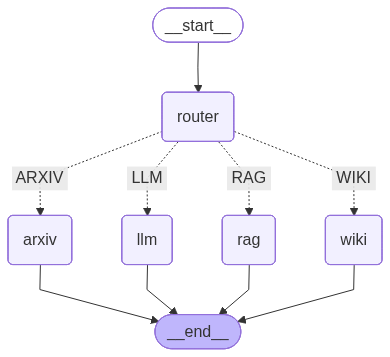

In [129]:
workflow

In [145]:
# Imports
from langgraph.graph import StateGraph, END
from typing import TypedDict
from langchain_openai import ChatOpenAI
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun
from langchain.chains import RetrievalQA
import os

# Step 1: Setup key manually
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)

# Step 2: Define the state schema
class State(TypedDict):
    query: str
    route: str
    response: str
    retriever: object

# Step 3: Create graph
graph = StateGraph(State)

# Step 4: Define nodes

def router_node(state: State):
    """Decide route OR directly answer."""
    query = state["query"]
    router_prompt = f"""
    You are an intelligent router.
    Task: Decide how to handle the user query:
    "{query}"

    Choose one of:
    - RAG: if related to AWS AI Practitioner or custom documents
    - WIKI: if it's about general world knowledge
    - ARXIV: if it's about research or academic topics
    - LLM: if it’s conversational or general

    If LLM is chosen, also answer the question directly.
    Return in JSON: {{"route": "<ROUTE>", "answer": "<YOUR_ANSWER>"}}
    """
    route_output = llm.predict(router_prompt)

    # ⚙️ Try to extract structured output
    import json
    try:
        parsed = json.loads(route_output)
        route = parsed.get("route", "LLM").strip().upper()
        answer = parsed.get("answer", "")
    except Exception:
        route, answer = "LLM", route_output

    # If LLM handled it directly, end here
    if route == "LLM" and answer:
        return {"route": route, "response": answer}

    return {"route": route}


def rag_node(state: State):
    retriever = state.get("retriever")
    if retriever is None:
        return {"response": "No retriever available for RAG."}
    rag_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)
    result = rag_chain.run(state["query"])
    return {"response": result}


def wiki_node(state: State):
    tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
    result = tool.run(state["query"])
    return {"response": result}


def arxiv_node(state: State):
    api = ArxivAPIWrapper()
    tool = ArxivQueryRun(api_wrapper=api)
    result = tool.run(state["query"])
    papers = api.run(state["query"])
    return {"response": f"{result}\n\n🔗 Related papers:\n{papers}"}


def refine_node(state: State):
    """Final LLM refinement before ending."""
    refine_prompt = f"""
    You are an expert assistant.
    The user asked: "{state['query']}"
    You got this response: "{state['response']}"

    Refine and summarize it clearly, keeping key points intact.
    """
    refined = llm.predict(refine_prompt)
    return {"response": refined}


# Step 5: Add nodes
graph.add_node("router", router_node)
graph.add_node("rag", rag_node)
graph.add_node("wiki", wiki_node)
graph.add_node("arxiv", arxiv_node)
graph.add_node("refine", refine_node)

# Step 6: Conditional routing
graph.add_conditional_edges(
    "router",
    lambda s: s["route"],
    {
        "RAG": "rag",
        "WIKI": "wiki",
        "ARXIV": "arxiv",
        "LLM": END,  # directly handled
    },
)

# Step 7: Add refinement step for all routed paths
graph.add_edge("rag", "refine")
graph.add_edge("wiki", "refine")
graph.add_edge("arxiv", "refine")
graph.add_edge("refine", END)

# Step 8: Set entry point and compile
graph.set_entry_point("router")
workflow = graph.compile()

# Step 9: Test
query = "Give me recent research on transformer architectures."
output = workflow.invoke({"query": query, "retriever": None})
print("\n🤖 Final Answer:\n", output["response"])



🤖 Final Answer:
 The response provided does not contain relevant information on recent research specifically about transformer architectures. Instead, it includes summaries of papers on unrelated topics, such as automotive manufacturing systems and micro-expression analysis. Here’s a refined summary of the content provided:

1. **Towards Industry 4.0: Gap Analysis between Current Automotive MES and Industry Standards using Model-Based Requirement Engineering** (Published: 2017-04-10)
   - **Authors**: Manoj Kannan Soundarapandian et al.
   - **Summary**: This paper discusses the gap between current automotive manufacturing execution systems (MES) and industrial standards (ISA-95, ISA-88) in the context of Industry 4.0. It employs a model-based requirements engineering approach to identify misalignments between standard requirements and existing software tool compliance.

2. **Micro-expression Spotting: A New Benchmark** (Published: 2020-12-28)
   - **Authors**: Thuong-Khanh Tran et al

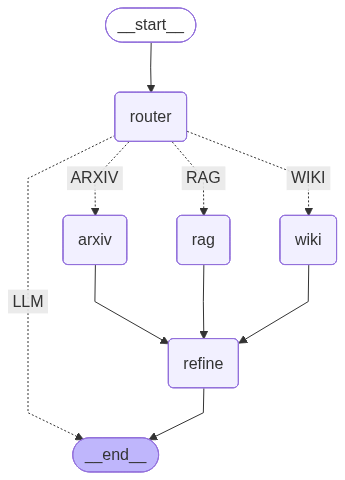

In [147]:
workflow